In [18]:
!apt-get update && apt-get install -y default-libmysqlclient-dev build-essential

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-libmysqlclient-dev is already the newest version (1.0.5ubuntu2).
The following additional packages will be installed:
  cpp cpp-9 dpkg-dev fakeroot g++ g++-9 gcc gcc-9 libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libdpkg-perl libfakeroot
  libfile-fcntllock-perl libgcc-9-dev liblocale-gettext-perl libstdc++-9-dev
  make xz-utils
Suggested packages:
  cpp-doc gcc-9-locales debian-keyring g++-multilib g++-9-multilib gcc-9-doc
  gcc-multilib manpages-dev libtool flex bison gdb gcc-doc gcc-9-mul

In [19]:
!pip install mysqlclient

  Using cached mysqlclient-2.1.1.tar.gz (88 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for mysqlclient: filename=mysqlclient-2.1.1-cp39-cp39-linux_x86_64.whl size=60515 sha256=c7f3d91613706baf7b18f519fc81a9b9b52f8b71cedbac525a28f7ea9603a8aa
  Stored in directory: /root/.cache/pip/wheels/f3/a5/27/c6312d8008951cfd5511684378a9e057b82006c70e1fea6107
Successfully built mysqlclient


In [1]:
from dask_kubernetes.experimental import KubeCluster

cluster = KubeCluster(name="rapids-dask",
                     image="rapidsai/rapidsai-core:22.08-cuda11.5-runtime-ubuntu20.04-py3.9",
                     worker_command="dask-cuda-worker",
                     n_workers=2,
                     resources={"limits": {"nvidia.com/gpu": "1"}},
                     env={"DISABLE_JUPYTER": "true"})

In [2]:
cluster

AttributeError: 'Tab' object has no attribute '_ipython_display_'

KubeCluster(rapids-dask, 'tcp://rapids-dask-cluster-service.kubeflow-user-example-com:8786', workers=2, threads=2, memory=29.30 GiB)

In [3]:
import optuna
import joblib
import dask.distributed

In [4]:
def objective(trial):
    x = trial.suggest_uniform("x", -10, 10)
    return (x - 2) ** 2

In [5]:
with dask.distributed.Client(cluster) as client:
    study = optuna.create_study(storage="mysql://root@10.36.2.20:3306/metadb")
    # Optimize in parallel on your Dask cluster
    with joblib.parallel_backend("dask"):
        study.optimize(objective, n_trials=100, n_jobs=-1)
    print(f"best_params = {study.best_params}")

[I 2022-09-28 06:27:16,407] A new study created in RDB with name: no-name-4dd7d24a-4b2c-469d-b43c-09f026abe9c7
/tmp/ipykernel_1658/638899847.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  x = trial.suggest_uniform("x", -10, 10)
[I 2022-09-28 06:27:16,704] Trial 1 finished with value: 34.37623492947794 and parameters: {'x': 7.863125013973175}. Best is trial 0 with value: 4.640744340718468.
[I 2022-09-28 06:27:16,706] Trial 0 finished with value: 4.640744340718468 and parameters: {'x': 4.154238691677055}. Best is trial 0 with value: 4.640744340718468.
[I 2022-09-28 06:27:16,749] Trial 2 finished with value: 24.08339889306909 and parameters: {'x': 6.907483967683348}. Best is trial 3 with value: 3.8178106751858794.
[I 2022-09-28 06:27:16,774] Trial 3 finished with value: 3.8178106751858794 and parameters: {'x': 3.953

best_params = {'x': 1.996483002617357}


In [6]:
study.best_params

{'x': 1.996483002617357}

In [7]:
study.best_value

1.2369270589517674e-05

In [81]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import log_loss
import xgboost as xgb
from optuna.samplers import TPESampler

In [90]:
def objective(trial):
    X, y = load_breast_cancer(return_X_y=True)
    params = {
        "n_estimators": 10,
        "verbosity": 0,
        "tree_method": "gpu_hist",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss"
    }
    clf = xgb.XGBClassifier(**params)
    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(clf, X, y, cv=fold, scoring='neg_log_loss')
    return score.mean()

In [91]:
with dask.distributed.Client(cluster) as client:
    study = optuna.create_study(storage="mysql://root@10.36.2.20:3306/metadb",
                                sampler=RandomSampler(seed=0),
                                direction="maximize")
    # Optimize in parallel on your Dask cluster
    with joblib.parallel_backend("dask"):
        study.optimize(objective, n_trials=200, n_jobs=-1)
    print(f"best_params = {study.best_params}")

[I 2022-09-28 07:19:24,651] A new study created in RDB with name: no-name-71853159-c7a4-4d34-b69d-28973215f105
[I 2022-09-28 07:19:25,952] Trial 2 finished with value: -0.6903889565452288 and parameters: {'lambda': 13.08082922103203, 'alpha': 5.89544770914824, 'colsample_bytree': 0.9002644775003046, 'max_depth': 6, 'min_child_weight': 4.0727930198777, 'learning_rate': 0.0004808566760066825, 'gamma': 0.25715310733708274}. Best is trial 2 with value: -0.6903889565452288.
[I 2022-09-28 07:19:25,989] Trial 0 finished with value: -0.6931470506792019 and parameters: {'lambda': 0.01811193920414608, 'alpha': 0.1771331198032584, 'colsample_bytree': 0.7674391502861992, 'max_depth': 5, 'min_child_weight': 3.8532466735026962, 'learning_rate': 1.5031541896009654e-08, 'gamma': 0.0012657281217265989}. Best is trial 2 with value: -0.6903889565452288.
[I 2022-09-28 07:19:26,186] Trial 3 finished with value: -0.6931436436643809 and parameters: {'lambda': 0.0016996092497966345, 'alpha': 8.726672799484726

best_params = {'alpha': 0.6535317091353735, 'colsample_bytree': 0.20871675141447837, 'gamma': 0.3579548848577648, 'lambda': 0.005931254527669017, 'learning_rate': 0.9512716862983326, 'max_depth': 9, 'min_child_weight': 1.392163252454128e-08}


In [92]:
study.best_params

{'alpha': 0.6535317091353735,
 'colsample_bytree': 0.20871675141447837,
 'gamma': 0.3579548848577648,
 'lambda': 0.005931254527669017,
 'learning_rate': 0.9512716862983326,
 'max_depth': 9,
 'min_child_weight': 1.392163252454128e-08}

In [93]:
study.best_value

-0.10163403264052413

In [97]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

/tmp/ipykernel_1658/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

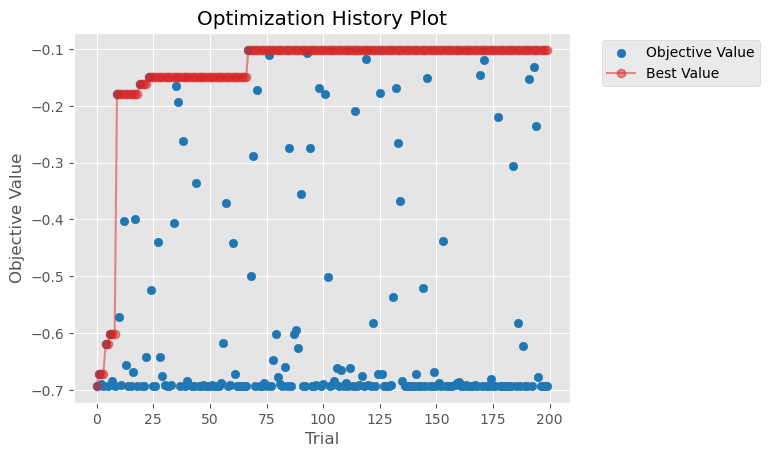

In [98]:
plot_optimization_history(study)

/tmp/ipykernel_1658/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

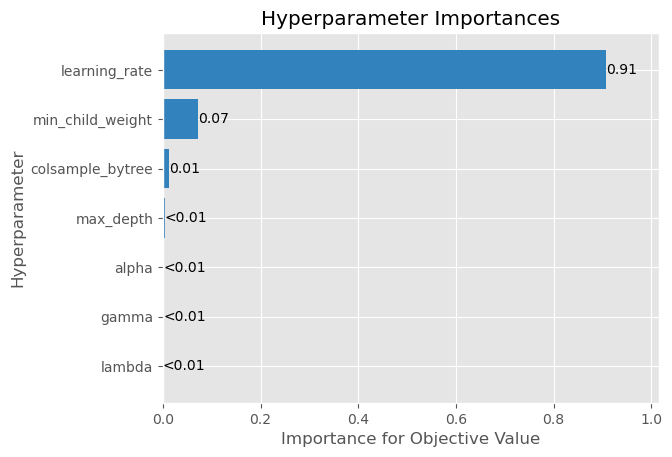

In [99]:
plot_param_importances(study)